# 图像恢复

## 1 实验介绍
图象是一种非常常见的信息载体，但是在图像的获取、传输、存储过程中可能由于各种原因使得图像受到噪声的影响。如何去除噪声的影响，恢复图像原本的信息是计算机视觉中的重要研究问题。

常见的图像恢复算法有基于空间域的中值滤波、基于小波域的小波去噪、基于偏微分方程的非线性扩散滤波等。本次实验对图像添加高斯噪声，并对添加噪声的图像进行基于线性回归模型的去噪。

## 2 实验目的
1. 学习Python的Opencv库进行图像相关处理
2. 学习Python的Numpy库进行相关数值计算
3. 学习线性回归模型的应用

## 3 导入实验环境
matplotlib数据库下的pyplot模块是一个常用于图像展示的模块；Numpy数据库用于相关的数值计算；cv2，即opencv库，计算机视觉库，常用于图像的处理；从sklearn.linear_model模块下导入线性回归(LinearRegression),岭回归(Ridge),Lasso回归。

岭回归(Ridge)：在线性回归的基础上加了L2正则化项(L2范数)，增加线性回归的泛化性能，它和一般线性回归的区别是在损失函数上增加了一个L2正则化的项，和一个调节线性回归项和正则化项权重的系数α。损失函数表达式如下：

$J(θ)=(1/2)(X_θ−Y)^T(X_θ−Y)+1/2α||θ||_2$

其中α为常数系数，需要进行调优。$||θ||_2$为L2范数。Ridge回归的解法和一般线性回归大同小异。

Lasso回归:有时也叫做线性回归的L1正则化，和Ridge回归的主要区别就是在正则化项，Ridge回归用的是L2正则化，而Lasso回归用的是L1正则化。Lasso回归的损失函数表达式如下：

$J(θ)=(1/2)(X_θ−Y)^T(X_θ−Y)+α||θ||_1$

其中α为常数系数，需要进行调优。$||θ||_1$为L1范数。


In [1]:
from matplotlib import pyplot as plt                             # 展示图片
import numpy as np                                               # 数值处理
import cv2                                                       # opencv库
from sklearn.linear_model import LinearRegression, Ridge, Lasso  # 回归分析

## 4 加载图片

In [2]:
def load_image(img_path):     #img_path:图像路径，一般为相对路径(将数据放于代码文件所在文件夹下)
    ''' 加载图片 '''

    # 通过opencv库，使用imread()方法将图片读取为BGR数值矩阵
    img = cv2.imread(img_path)
    
    # 如果读入的图像为BGR数值矩阵，将其转换为RGB图像
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #参数cv2.COLOR_BGR2RGB表示图像由BGR转换为RGB
    
    # 为了方便后续随机噪声mask图像后用于区别mask区域（像素值都将变为0），将原始图像=0的值变为0.01（PS:一般图片不会出现数值0）
    img[(img == 0)] = 0.01
        
    return img

## 5 添加噪声

In [3]:
def add_noise(img, noise_ratio):   #img：处理的图像对象；noise_ratio:噪声
    ''' 添加噪声 '''
    
    # 采用二值伯努利分布按比例采样mask噪声
    #numpy.random.binomial(n,p,size=None)，n:一次实验的样本数，此次实验针对一张图片；以(1 - noise_ratio)的概率获取像素，最终以图片的尺寸返回结果
    noise_img = np.random.binomial(1, 1 - noise_ratio, size=img.shape) 
    
    # 矩阵乘法，用噪声mask掉图像上的对应元素
    noise_img = np.multiply(noise_img,img)

    return noise_img

## 6 数据最大值归一化

In [4]:
def normalization(img):
    ''' 最大值归一化 '''
    
    return img / np.max(img)  #图像中的所有像素点除以其中的最大值，做归一化处理

## 7 恢复图像

In [5]:
def restore(img, domain_length):  #参数img：研究的图像对象； domain_length:像素点周围的区域长度
    ''' 
    区域二元线性回归模型 -- 图像恢复 
    :param domain_length: 区域大小
    :return: 恢复过后的图像矩阵
    '''
    
    # 深拷贝图像矩阵
    resImg = np.copy(img)
    
    # 区别噪声mask
    noiseMask = np.array(img != 0, dtype='double')
    
    # 获取图像矩阵大小的各个维度值，行，列，通道
    rows, cols, channel = img.shape
    
    count = 0   #控制拟合的次数
    for row in range(rows):
        for col in range(cols):
            for chan in range(channel):
                # 如果该像素识别未添加过噪声，就不对其进行恢复
                if noiseMask[row, col, chan] != 0.:
                    continue
                    
                x_train = []
                y_train = []
                for i in range(row-domain_length, row+domain_length):
                    # 边界条件，超出图像行范围的不考虑
                    if i < 0 or i >= row:
                        continue
                    for j in range(col-domain_length, col+domain_length):
                        # 边界条件，超出图像列范围的不考虑
                        if j < 0 or j >= col:
                            continue
                        # 被噪声mask掉的区域不参与真实图像回归
                        elif noiseMask[i, j, chan] == 0.:
                            continue
                        # 自己不作为真实图像回归的一部分
                        elif i == row and j == col:
                            continue
                        # 其余符合条件的区域内的像素点作为二元拟合的样本
                        x_train.append([i, j])
                        y_train.append([img[i, j, chan]])
                        
                #如果不存在可拟合的样本，就跳过
                if x_train == []:
                    continue
                
                # 区域二元线性拟合
                Regression = LinearRegression()    #导入线性回归函数
                Regression.fit(x_train, y_train)   #拟合训练集数据
                resImg[row, col, chan] = Regression.predict([[row, col]])  #使用模型预测点(row, col, chan)的原始像素值
            
            # 每5000次拟合进行一次输出
            count += 1
            if count % 5000 == 0:
                print("picture restored:" +
                      str(float(count)/rows/cols))
                
    print("picture restore finish!")
    return resImg

## 8 评估指标

In [6]:
def loss(img_1, img_2):
    ''' 采用2-范数进行loss计算 '''
    
    loss_ = np.sqrt(np.sum(np.power(img_1 - img_2, 2)))
    return loss_

## 9 保存图像

In [7]:
def save_image(img_, img_path):        #img_path:保存到本地的文件夹路径
    ''' 采用opencv库将图像保存到本地'''

    img = np.copy(img_)     #深拷贝图像
    
    # 从给定数组的形状中删除维度为1的条目
    img = img.squeeze()
    
    # 将图片数据存储类型改为 np.uint8
    if img.dtype == np.double:
        
        #np.iinfo(np.unit8).max找到unit8数据类型中的最大值。
        img = img * np.iinfo(np.uint8).max   
        
        # 转换图片数组数据类型
        img = img.astype(np.uint8)
    
    # 将 RGB 方式转换为 BGR 方式
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # 生成图片
    cv2.imwrite(img_path, img)

## 10 显示干净图片

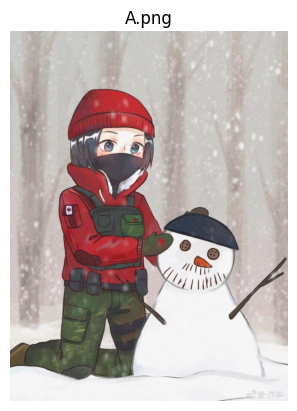

In [8]:
# 图片路径
img_path = 'data/A.png'

# 加载图片
img = load_image(img_path)
img = normalization(img)      #归一化图片

# 展示图片
plt.title('A.png')
plt.axis('off')
plt.imshow(img)
plt.show()

## 11 噪声图片

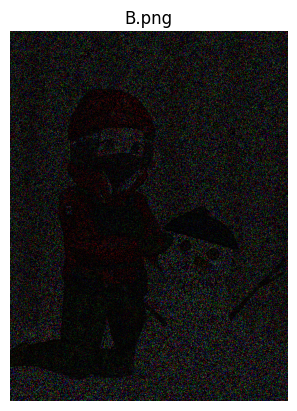

The loss is:  1136.720343758929


In [9]:
noise_img = add_noise(img, 0.9)  #img：原图； 噪声比例：0.9

# 展示噪声图片
plt.title('B.png')
plt.axis('off')
plt.imshow(noise_img)
plt.show()

# 保存噪声图片
save_image(noise_img,'data/B.png') #在data文件夹下面

# 计算距离
print("The loss is: ", loss(img, noise_img))

## 12 图像的恢复

In [ ]:
res_img = restore(noise_img, 3)  #将噪声图片作为输入，domain_length:3

# 展示恢复图片
plt.title('C.png')
plt.axis('off')
plt.imshow(res_img)

# 保存恢复图像
save_image(res_img,'data/C.png') #在data文件夹下

# 计算距离
print("The loss is: ", loss(img, res_img))

picture restored:0.005469789259959393
picture restored:0.010939578519918785
picture restored:0.016409367779878177
picture restored:0.02187915703983757
picture restored:0.02734894629979696
picture restored:0.032818735559756354
picture restored:0.038288524819715744
picture restored:0.04375831407967514
picture restored:0.04922810333963453
picture restored:0.05469789259959392
picture restored:0.06016768185955332
picture restored:0.06563747111951271
picture restored:0.0711072603794721
picture restored:0.07657704963943149
picture restored:0.08204683889939089
picture restored:0.08751662815935028
picture restored:0.09298641741930967
picture restored:0.09845620667926906
picture restored:0.10392599593922845
picture restored:0.10939578519918784
picture restored:0.11486557445914723
picture restored:0.12033536371910664
picture restored:0.12580515297906603
picture restored:0.13127494223902542
picture restored:0.1367447314989848
picture restored:0.1422145207589442
picture restored:0.1476843100189036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


picture restore finish!
The loss is:  716.795099053213


## 13 修复图像的展示

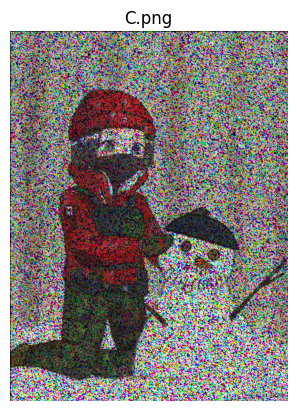

In [12]:
# 图片路径
img_path = 'data/C.png'

# 加载图片
img = load_image(img_path)
img = normalization(img)

# 展示图片
plt.title('C.png')
plt.axis('off')
plt.imshow(img)
plt.show()